# Entregable 1 | Data Preparation
Integrantes:
* José Ruz
* Eduardo Bayarri
* Victor Cuenca
* Alan Jaén

# Enunciado
El primer entregable a realizar, se trata de un fichero con datos de coches de BMW, el objetivo es predecir el precio (ojo que no hay que hacer la predicción pero es el objetivo a tener en cuenta),
para ello hay que realizar la limpieza y preprocesamiento de datos

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#importamos librería
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler

import folium
import plotly.express as px

In [3]:
#LEEMOS EL FICHERO DE BMW
df_bmw = pd.read_csv("/content/drive/MyDrive/Proyecto DSMarket/Entregables/Entregable 1 | Data Preparation/bmw_pricing_v3.csv")


In [4]:
df_bmw1 = df_bmw.copy()

In [5]:
#1. ¿Qué columnas eliminaron inicialmente del dataset y por qué?

In [6]:
#Eliminamos la columna marca, ya que sabemos que es una base de datos de bmw, y para los valores informados solo se usa "BMW"
df_bmw1 = df_bmw1.drop("marca",axis=1)

#Eliminamos la columna fecha_venta ya que no representa un peso importante a la hora de predecir el precio
df_bmw1 = df_bmw1.drop("fecha_venta",axis=1)


In [7]:
#Vemos si hay duplicados
len(df_bmw1[df_bmw1.duplicated(keep=False)])

0

In [8]:
#Corregimos el tipo de datos de los campos
#Fechas
df_bmw1["fecha_registro"] = pd.to_datetime(df_bmw1["fecha_registro"])

#Booleanos, así los valores que tenemos a nulos los interpretamos como Falsos.
for i in df_bmw1.columns:
  if any(df_bmw1[i].iloc[:5].isin([True,False])):
    df_bmw1[i] = df_bmw1[i].astype(bool)


In [9]:
df_bmw1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   modelo                       4840 non-null   object        
 1   km                           4841 non-null   float64       
 2   potencia                     4842 non-null   float64       
 3   fecha_registro               2420 non-null   datetime64[ns]
 4   tipo_gasolina                4838 non-null   object        
 5   color                        4398 non-null   object        
 6   tipo_coche                   3383 non-null   object        
 7   volante_regulable            4843 non-null   bool          
 8   aire_acondicionado           4843 non-null   bool          
 9   camara_trasera               4843 non-null   bool          
 10  asientos_traseros_plegables  4843 non-null   bool          
 11  elevalunas_electrico         4843 non-null 

In [10]:
df_bmw1.isnull().sum()

modelo                            3
km                                2
potencia                          1
fecha_registro                 2423
tipo_gasolina                     5
color                           445
tipo_coche                     1460
volante_regulable                 0
aire_acondicionado                0
camara_trasera                    0
asientos_traseros_plegables       0
elevalunas_electrico              0
bluetooth                         0
gps                               0
alerta_lim_velocidad              0
precio                            6
dtype: int64

In [11]:
#2. Manejo de nulos, explicar qué se hizo con los nulos por cada columna

In [12]:
df_bmw2 = df_bmw1.copy()

In [13]:
#Se eliminan los registros de las columnas con poca cantidad de nulos
for i in df_bmw2.columns:
  if df_bmw2[i].isnull().sum() < 10:
    df_bmw2.dropna(subset=[i],inplace=True)

#Se eliminan 61 filas donde las columnas fecha_registro, color y tipo_coche están a null
nulos = df_bmw2[df_bmw2['fecha_registro'].isnull() & df_bmw2['color'].isnull() & df_bmw2['tipo_coche'].isnull()].index
df_bmw2 = df_bmw2.drop(nulos)

#Los nulos de tipo_coche restante se informan como 'SIN INFO'
df_bmw2 =df_bmw2.dropna(subset=['tipo_coche'])

#Los nulos de color restantes se informan como 'SIN INFO'
df_bmw2 =df_bmw2.dropna(subset=['color'])

#Para los nulos de fecha_registro restantes se ha decidido borrarlo para una mejor precisión en la predicción del precio
df_bmw2 =df_bmw2.dropna(subset=['fecha_registro'])

In [14]:
df_bmw2.isnull().sum()

modelo                         0
km                             0
potencia                       0
fecha_registro                 0
tipo_gasolina                  0
color                          0
tipo_coche                     0
volante_regulable              0
aire_acondicionado             0
camara_trasera                 0
asientos_traseros_plegables    0
elevalunas_electrico           0
bluetooth                      0
gps                            0
alerta_lim_velocidad           0
precio                         0
dtype: int64

In [15]:
#3. Análisis univariable, explicar alguna información interesante encontrada

In [16]:
df_bmw3 = df_bmw2.copy()

In [17]:
df_bmw3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1521 entries, 7 to 4841
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   modelo                       1521 non-null   object        
 1   km                           1521 non-null   float64       
 2   potencia                     1521 non-null   float64       
 3   fecha_registro               1521 non-null   datetime64[ns]
 4   tipo_gasolina                1521 non-null   object        
 5   color                        1521 non-null   object        
 6   tipo_coche                   1521 non-null   object        
 7   volante_regulable            1521 non-null   bool          
 8   aire_acondicionado           1521 non-null   bool          
 9   camara_trasera               1521 non-null   bool          
 10  asientos_traseros_plegables  1521 non-null   bool          
 11  elevalunas_electrico         1521 non-null   boo

In [18]:
##--MODELO--##

#Creamos un mapeo para los modelos
#S. indica "Serie"
serie_modelos ={'^1.*': 'S. 1',#'^M1.*': 'S. 1',
                '^2.*': 'S. 2',
                '^3.*': 'S. 3',#'^M3.*': 'S. 3',
                '^4.*': 'S. 4',#'^M4.*': 'S. 4',
                '^5.*': 'S. 5',#'^M5.*': 'S. 5',
                '^6.*': 'S. 6',
                '^7.*': 'S. 7',
                '^8.*': 'S. 8',
                '^X.*': 'S. X',
                '^M.*': 'S. M',
                }

#Sustituimos los modelos por su respectiva serie
df_bmw3['modelo']= df_bmw3['modelo'].replace(serie_modelos, regex=True)

#Los modelos donde solo haya 1 registro con ese modelo los almacenamos en OTROS
#conteo_modelos = df_bmw3['modelo'].value_counts()
#df_bmw3.loc[df_bmw3['modelo'].isin(conteo_modelos[conteo_modelos == 1].index), 'modelo'] = "OTROS"

#Eliminamos los modelos que solo se repiten 1 vez ya que eran pocos (3 aprox)
frecuencia = df_bmw3['modelo'].value_counts()
df_bmw3 = df_bmw3[~df_bmw3['modelo'].isin(frecuencia[frecuencia == 1].index)]

In [19]:
df_bmw3['modelo'].value_counts()

modelo
S. 3    541
S. 5    383
S. X    355
S. 1    156
S. 4     32
S. 7     21
S. 2     13
S. 6      8
S. M      8
Name: count, dtype: int64

In [20]:
##--KILOMETROS(KM)--##

#Redondeamos los kilometros a 1000 (Ej: 27920km pasa a 28000km)
df_bmw3["km"] = round(df_bmw3["km"] / 1000) * 1000

#Cambiamos el tipo de dato a de float64 a int para eliminar los decimales
df_bmw3["km"] = df_bmw3["km"].astype(int)

<ipython-input-20-b22cc64101e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmw3["km"] = round(df_bmw3["km"] / 1000) * 1000
<ipython-input-20-b22cc64101e2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmw3["km"] = df_bmw3["km"].astype(int)


In [21]:
##--POTENCIA--##

#Redondeamos la potencia a 10 (Ej: 75 cv pasa a 80 cv)
df_bmw3["potencia"] = round(df_bmw3["potencia"] / 10) * 10

#Cambiamos el tipo de dato a de float64 a int para eliminar los decimales
df_bmw3["potencia"] = df_bmw3["potencia"].astype(int)

#Eliminamos los registros que tengan 0 cv
df_bmw3 = df_bmw3.drop(df_bmw3[df_bmw3['potencia'] == 0].index)

<ipython-input-21-1cd92387e3bd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmw3["potencia"] = round(df_bmw3["potencia"] / 10) * 10
<ipython-input-21-1cd92387e3bd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmw3["potencia"] = df_bmw3["potencia"].astype(int)


In [22]:
##--FECHA_REGISTRO--##

#Modificamos la fecha para agrupar por año
df_bmw3["fecha_registro"] = df_bmw3["fecha_registro"].dt.year

#Renombramos la columna a AÑO
df_bmw3 = df_bmw3.rename(columns={'fecha_registro': 'año'})

In [23]:
##--TIPO_GASOLINA--##

#Se corrigen los datos
df_bmw3['tipo_gasolina'] = df_bmw3['tipo_gasolina'].replace("Diesel","diesel")

df_bmw3["tipo_gasolina"].value_counts()



tipo_gasolina
diesel    1456
petrol      60
Name: count, dtype: int64

In [24]:
##--TIPO_COCHE--##

#No se modifica
#df_bmw3["tipo_coche"].value_counts()

In [25]:
df_bmw3[(df_bmw3['precio'] <= 1000) & (df_bmw3['año'] >= 2005)]

,modelo,km,potencia,año,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio
188,S. 3,130000,80,2014,diesel,white,estate,False,False,False,True,False,False,False,True,800.0
245,S. 3,151000,140,2012,diesel,blue,estate,False,False,False,False,False,False,True,False,800.0
647,S. 5,177000,160,2014,diesel,black,estate,True,True,True,True,False,False,True,True,800.0
879,S. 3,134000,100,2014,diesel,grey,estate,False,True,False,True,False,False,False,True,100.0
1832,S. 1,175000,80,2014,diesel,blue,hatchback,False,True,False,True,False,False,True,True,100.0
3798,S. X,111000,140,2015,diesel,white,suv,False,False,False,True,False,False,False,False,800.0
3801,S. X,154000,100,2013,diesel,black,suv,False,False,False,True,False,False,False,True,800.0
4356,S. X,80000,190,2014,diesel,black,suv,False,False,False,True,False,False,False,True,100.0


In [26]:
##--PRECIO--##

#Cambiamos el tipo de dato de float64 a int para eliminar los decimales
df_bmw3["precio"] = df_bmw3["precio"].astype(int)

#Borramos los registros donde el valor es inferior a 1000 y el año superior a 2005 ya que pueden ser registros erroneos.
df_bmw3 = df_bmw3[(df_bmw3['precio'] >= 1000) & (df_bmw3['año'] >= 2005)]

In [27]:
##--COLUMNAS BOOLEANAS--##

#Agrupación de columnas consideradas extras

#Creamos una variable en la que almacenamos las columnas que consideramos extras
col_extras = df_bmw3.select_dtypes(include=bool)

#Generamos una columna con el número de extras de modelo
N_Extras = (col_extras == True).sum(axis=1)
df_bmw3["N_Extras"] = N_Extras

#Añadimos otra columna donde especificamos los extras que tiene cada modelo

ls_extras = []
for index, fila in col_extras.iterrows():
  #Indicamos que si el modelo no tiene extras lo guarde como sin extras.
  if df_bmw3['N_Extras'][index] == 0:
    ls_extras.append("Sin Extras")
  else:
   ls_extras.append(fila.index[fila].tolist())

df_bmw3["Extras"]= ls_extras

#Por ultimo eliminamos estas columnas
for i in col_extras:
  df_bmw3 = df_bmw3.drop(columns=[i],axis=1)

<ipython-input-27-87719b2f1a7e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmw3["N_Extras"] = N_Extras
<ipython-input-27-87719b2f1a7e>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bmw3["Extras"]= ls_extras


In [28]:
df_bmw3 = df_bmw3.reset_index(drop=True)

In [29]:
#4. Análisis de correlación inicial

In [30]:
df_bmw4 = df_bmw3.copy()

In [31]:
df_bmw4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   modelo         1481 non-null   object
 1   km             1481 non-null   int64 
 2   potencia       1481 non-null   int64 
 3   año            1481 non-null   int32 
 4   tipo_gasolina  1481 non-null   object
 5   color          1481 non-null   object
 6   tipo_coche     1481 non-null   object
 7   precio         1481 non-null   int64 
 8   N_Extras       1481 non-null   int64 
 9   Extras         1481 non-null   object
dtypes: int32(1), int64(4), object(5)
memory usage: 110.0+ KB


In [32]:
#Vemos que no hay ninguna variable con una fuerte correlación

In [33]:
corr = df_bmw4.corr(numeric_only = True)
corr.style.background_gradient(cmap='coolwarm')

,km,potencia,año,precio,N_Extras
km,1.000000,-0.042833,-0.502285,-0.393827,0.045977
potencia,-0.042833,1.000000,0.073613,0.597189,0.506291
año,-0.502285,0.073613,1.000000,0.409219,0.069831
precio,-0.393827,0.597189,0.409219,1.000000,0.380623
N_Extras,0.045977,0.506291,0.069831,0.380623,1.000000


In [34]:
df_bmw4["log_precio"]=np.log10(df_bmw4["precio"])

<Axes: >

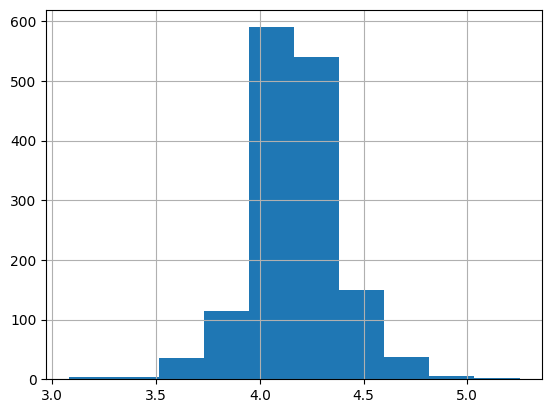

In [35]:
df_bmw4['log_precio'].hist()

<Axes: xlabel='log_precio'>

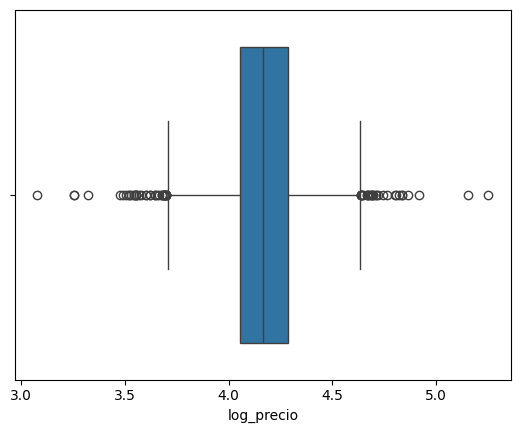

In [36]:
sns.boxplot(x=df_bmw4["log_precio"])

In [37]:
#5. Análisis variable vs target, ¿Hay algún insight interesante?

In [38]:
#Parece que modelo, km, potencia y año son interesantes.

In [39]:
df_bmw5 = df_bmw4.copy()

In [40]:
#Eliminamos la columna donde vemos los extras que se usan porque al ser una columna
#informada con listas falla a la hora del analisis
df_bmw5 = df_bmw5.drop(columns=['Extras'])

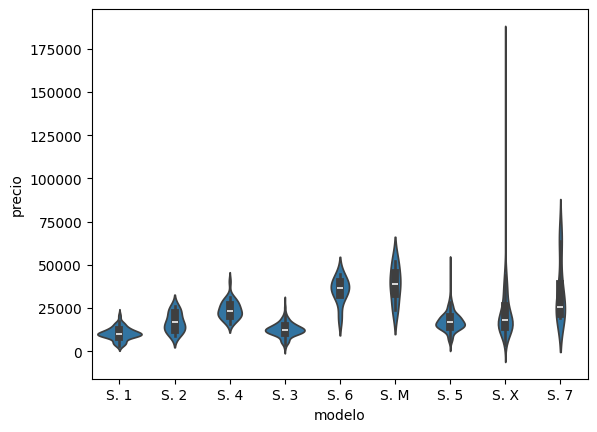

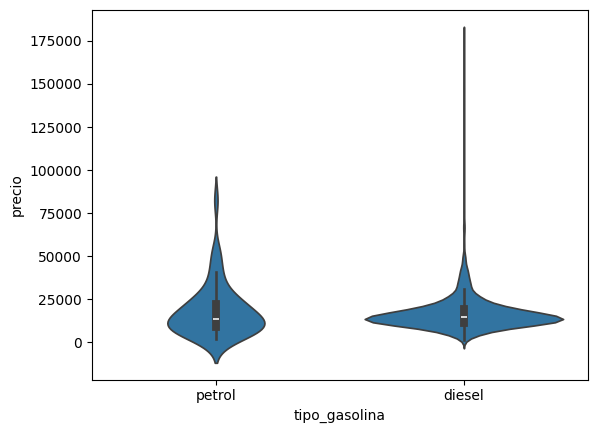

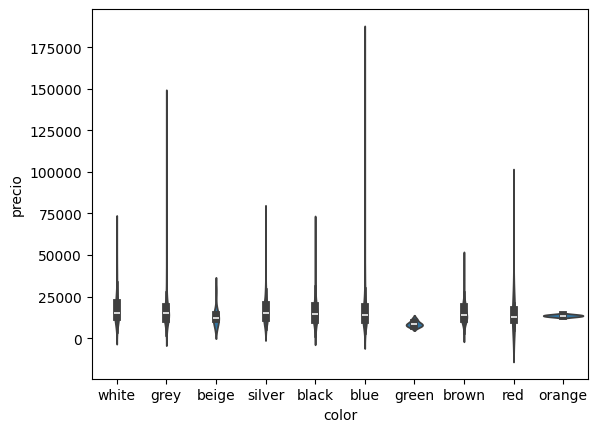

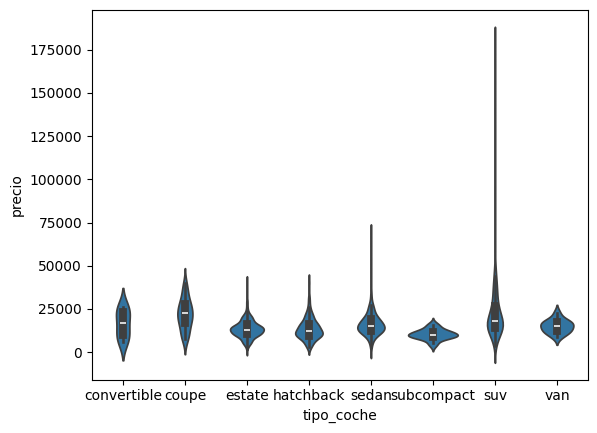

In [41]:
for i in df_bmw5:
  if (df_bmw5[i].dtype.kind =="O"):
    plt.figure()
    sns.violinplot(x=i,y="precio", data=df_bmw5)

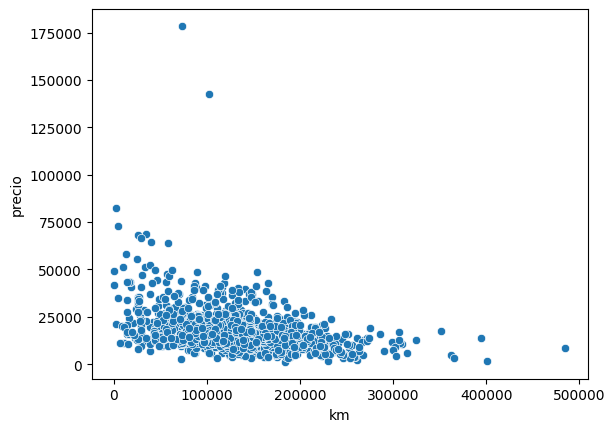

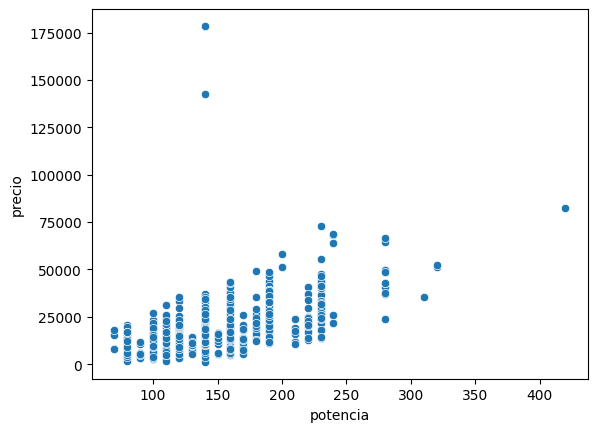

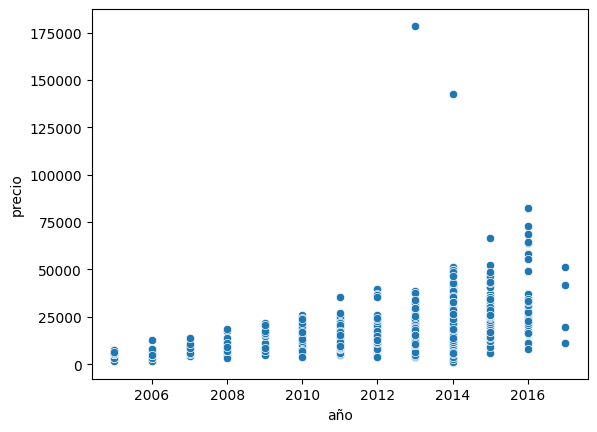

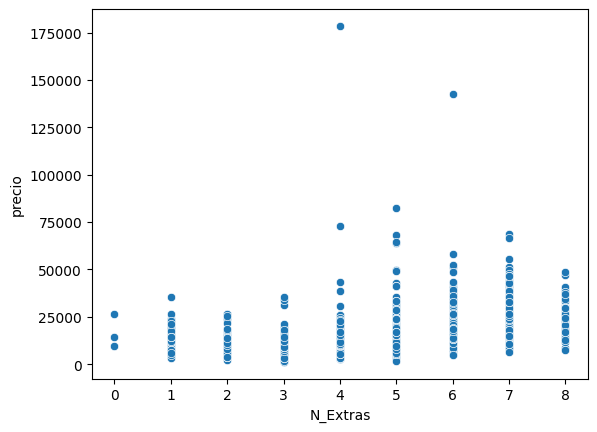

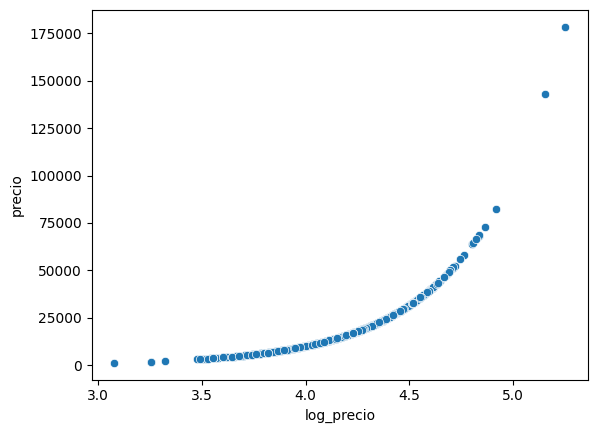

In [42]:
for i in df_bmw5:
  if (df_bmw5[i].dtype.kind in ("i","f")) and (i!="precio"):
    plt.figure()
    sns.scatterplot(x=i,y="precio", data=df_bmw5)

In [43]:
#6. Transformación de categóricas a numéricas, ¿Qué variables van a transformar? ¿Que técnica se va usar?

In [44]:
df_bmw6 = df_bmw5.copy()

In [45]:
target= ["precio","LOG_PRECIO"]

In [46]:
def obtener_lista_variables(dataset):
    lista_numericas=[]
    lista_boolean=[]
    lista_categoricas=[]

    for i in dataset:
        if    (dataset[i].dtype.kind in ("f","i")) and len(dataset[i].unique())!= 2  and i not in target:
              lista_numericas.append(i)
        elif  (dataset[i].dtype.kind in ("f","i")) and len(dataset[i].unique())== 2  and i not in target:
              lista_boolean.append(i)
        elif  (dataset[i].dtype.kind == "O")  and i not in target:
              lista_categoricas.append(i)

    return lista_numericas, lista_boolean, lista_categoricas

In [47]:
lista_numericas, lista_boolean, lista_categoricas= obtener_lista_variables(df_bmw6)

In [48]:
lista_categoricas

['modelo', 'tipo_gasolina', 'color', 'tipo_coche']

In [49]:
lista_numericas

['km', 'potencia', 'año', 'N_Extras', 'log_precio']

In [50]:
lista_boolean

[]

In [51]:
df_bmw_prep=pd.get_dummies(data=df_bmw6,
                               columns=lista_categoricas
                               )

In [52]:
pd.set_option('display.max_columns', None)

In [53]:
df_bmw_prep.head()

,km,potencia,año,precio,N_Extras,log_precio,modelo_S. 1,modelo_S. 2,modelo_S. 3,modelo_S. 4,modelo_S. 5,modelo_S. 6,modelo_S. 7,modelo_S. M,modelo_S. X,tipo_gasolina_diesel,tipo_gasolina_petrol,color_beige,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_red,color_silver,color_white,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
0,116000,100,2009,6100,5,3.785330,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
1,209000,130,2008,8300,6,3.919078,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
2,21000,140,2015,21900,4,4.340444,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
3,126000,220,2013,16800,4,4.225309,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False
4,90000,140,2014,26300,7,4.419956,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False


In [54]:
pd.reset_option("max_columns")

In [55]:
df_bmw_prep.head()

,km,potencia,año,precio,N_Extras,log_precio,modelo_S. 1,modelo_S. 2,modelo_S. 3,modelo_S. 4,...,color_silver,color_white,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
0,116000,100,2009,6100,5,3.785330,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,209000,130,2008,8300,6,3.919078,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,21000,140,2015,21900,4,4.340444,False,True,False,False,...,False,True,True,False,False,False,False,False,False,False
3,126000,220,2013,16800,4,4.225309,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
4,90000,140,2014,26300,7,4.419956,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False


In [56]:
#7. Escalar variables (usando minmaxscaler) y luego aplicar la correlación final de variables
#¿Hay alguna variable finalmente correlacionada?

In [57]:
def minmaxTransformacion(variable_transformar):
    minMaxResultado=MinMaxScaler()
    df_bmw_prep[variable_transformar]=minMaxResultado.fit_transform(df_bmw_prep[variable_transformar].values.reshape(-1,1))
    return minMaxResultado

In [58]:
for i in lista_numericas:
  print(i)

km
potencia
año
N_Extras
log_precio


In [59]:
for i in lista_numericas:
  globals()[f"minMax_{i}"] = minmaxTransformacion(i)

In [60]:
df_bmw_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 35 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   km                      1481 non-null   float64
 1   potencia                1481 non-null   float64
 2   año                     1481 non-null   float64
 3   precio                  1481 non-null   int64  
 4   N_Extras                1481 non-null   float64
 5   log_precio              1481 non-null   float64
 6   modelo_S. 1             1481 non-null   bool   
 7   modelo_S. 2             1481 non-null   bool   
 8   modelo_S. 3             1481 non-null   bool   
 9   modelo_S. 4             1481 non-null   bool   
 10  modelo_S. 5             1481 non-null   bool   
 11  modelo_S. 6             1481 non-null   bool   
 12  modelo_S. 7             1481 non-null   bool   
 13  modelo_S. M             1481 non-null   bool   
 14  modelo_S. X             1481 non-null   

In [61]:
df_bmw_prep.head()

,km,potencia,año,precio,N_Extras,log_precio,modelo_S. 1,modelo_S. 2,modelo_S. 3,modelo_S. 4,...,color_silver,color_white,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
0,0.237603,0.085714,0.333333,6100,0.625,0.325046,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,0.429752,0.171429,0.250000,8300,0.750,0.386611,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0.041322,0.200000,0.833333,21900,0.500,0.580570,False,True,False,False,...,False,True,True,False,False,False,False,False,False,False
3,0.258264,0.428571,0.666667,16800,0.500,0.527572,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
4,0.183884,0.200000,0.750000,26300,0.875,0.617170,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False


In [62]:
corr = df_bmw_prep.corr(numeric_only=True)

In [63]:
pd.set_option("display.max_rows",None)

In [64]:
pd.reset_option("max_rows")

In [65]:
corr.style.background_gradient(cmap='coolwarm')

,km,potencia,año,precio,N_Extras,log_precio,modelo_S. 1,modelo_S. 2,modelo_S. 3,modelo_S. 4,modelo_S. 5,modelo_S. 6,modelo_S. 7,modelo_S. M,modelo_S. X,tipo_gasolina_diesel,tipo_gasolina_petrol,color_beige,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_red,color_silver,color_white,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
km,1.000000,-0.042833,-0.502285,-0.393827,0.045977,-0.454287,-0.166468,-0.117611,0.109244,-0.095613,0.191084,-0.017086,-0.023519,-0.034394,-0.124474,0.076709,-0.076709,0.016331,0.062426,-0.032412,-0.023159,0.019287,0.033356,-0.022812,-0.023471,0.002350,-0.085957,-0.034971,-0.040713,0.198944,-0.132554,0.072723,-0.082467,-0.122100,-0.084900
potencia,-0.042833,1.000000,0.073613,0.597189,0.506291,0.620327,-0.324975,-0.057972,-0.290048,0.061836,0.202894,0.172892,0.199708,0.283076,0.214162,-0.147249,0.147249,-0.023863,0.044251,-0.009919,-0.082097,-0.016183,0.008006,-0.001249,0.009772,-0.005788,0.005174,0.009676,0.136692,-0.061640,-0.209802,0.041012,-0.166337,0.214308,-0.056386
año,-0.502285,0.073613,1.000000,0.409219,0.069831,0.574647,-0.033254,0.116224,-0.028536,0.120846,-0.025213,0.002189,0.014669,0.039143,0.003932,0.106258,-0.106258,-0.031439,-0.060079,0.041489,0.012142,-0.090201,-0.042627,0.005702,0.035740,-0.012721,0.116135,-0.028805,0.014234,-0.008440,0.049586,-0.060592,0.012684,0.005843,0.097101
precio,-0.393827,0.597189,0.409219,1.000000,0.380623,0.860527,-0.209709,0.001313,-0.294783,0.108254,0.031590,0.133329,0.194882,0.157979,0.312044,-0.026250,0.026250,-0.023803,-0.002844,-0.000876,-0.030455,-0.045733,-0.010582,-0.011254,0.016303,0.004153,0.049906,-0.001404,0.078908,-0.213661,-0.114761,0.020582,-0.088638,0.313952,-0.014321
N_Extras,0.045977,0.506291,0.069831,0.380623,1.000000,0.485419,-0.304734,-0.066895,-0.215839,0.059672,0.290549,0.111153,0.107752,0.067654,0.101345,0.017060,-0.017060,-0.032705,0.064844,-0.023283,-0.021725,-0.000677,0.015735,-0.017792,-0.060943,-0.001838,-0.045135,0.013144,0.056568,-0.007964,-0.144021,0.064556,-0.157273,0.104030,-0.065959
log_precio,-0.454287,0.620327,0.574647,0.860527,0.485419,1.000000,-0.287944,0.016092,-0.325990,0.142649,0.123739,0.126407,0.170502,0.138837,0.305515,0.030186,-0.030186,-0.024327,-0.012409,-0.015365,-0.015330,-0.064576,-0.009654,-0.006164,-0.000250,0.022581,0.062452,-0.001298,0.096539,-0.226392,-0.141695,0.062402,-0.115666,0.307345,-0.001199
modelo_S. 1,-0.166468,-0.324975,-0.033254,-0.209709,-0.304734,-0.287944,1.000000,-0.032174,-0.253738,-0.050808,-0.197660,-0.025196,-0.038976,-0.025196,-0.189838,-0.116882,0.116882,-0.026734,0.010187,0.063405,-0.030764,-0.019899,-0.049015,-0.012573,0.002338,0.005641,0.008914,0.072920,-0.051614,-0.229551,0.630927,-0.190409,0.420565,-0.189126,-0.030901
modelo_S. 2,-0.117611,-0.057972,0.116224,0.001313,-0.066895,0.016092,-0.032174,1.000000,-0.069839,-0.013985,-0.054404,-0.006935,-0.010728,-0.006935,-0.052251,-0.021926,0.021926,-0.007358,-0.025316,-0.018665,0.006663,-0.005477,-0.000934,-0.003461,0.055625,0.003797,0.037206,0.204598,0.034837,-0.065768,-0.037291,-0.053817,-0.013531,-0.052056,0.798951
modelo_S. 3,0.109244,-0.290048,-0.028536,-0.294783,-0.215839,-0.325990,-0.253738,-0.069839,1.000000,-0.110289,-0.429059,-0.054693,-0.084605,-0.054693,-0.412079,0.016353,-0.016353,0.050896,-0.044986,0.018215,0.085431,0.029777,-0.028611,-0.027291,0.033570,-0.006561,0.000789,-0.030572,-0.035564,0.346735,-0.059274,0.135429,-0.106713,-0.410534,-0.051338
modelo_S. 4,-0.095613,0.061836,0.120846,0.108254,0.059672,0.142649,-0.050808,-0.013985,-0.110289,1.000000,-0.085914,-0.010952,-0.016941,-0.010952,-0.082515,-0.048339,0.048339,-0.011620,0.043380,-0.009311,-0.037576,-0.008649,-0.027594,-0.005465,-0.016484,-0.002586,0.023082,0.057468,0.575369,-0.103860,0.090265,-0.074211,-0.021368,-0.082205,-0.013431


In [66]:
#Decidimos borrar la columna de serie X en vez de clase tipo_coche_suv
#porque debido a su correlación, casi todos los serie X
#son suv pero no todos los suv son Serie X
df_bmw_prep = df_bmw_prep.drop(columns=['modelo_S. X'])

In [67]:
corr = df_bmw_prep.corr(numeric_only=True)

In [68]:
pd.set_option("display.max_rows",None)

In [69]:
pd.reset_option("max_rows")

In [70]:
corr.style.background_gradient(cmap='coolwarm')

,km,potencia,año,precio,N_Extras,log_precio,modelo_S. 1,modelo_S. 2,modelo_S. 3,modelo_S. 4,modelo_S. 5,modelo_S. 6,modelo_S. 7,modelo_S. M,tipo_gasolina_diesel,tipo_gasolina_petrol,color_beige,color_black,color_blue,color_brown,color_green,color_grey,color_orange,color_red,color_silver,color_white,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
km,1.000000,-0.042833,-0.502285,-0.393827,0.045977,-0.454287,-0.166468,-0.117611,0.109244,-0.095613,0.191084,-0.017086,-0.023519,-0.034394,0.076709,-0.076709,0.016331,0.062426,-0.032412,-0.023159,0.019287,0.033356,-0.022812,-0.023471,0.002350,-0.085957,-0.034971,-0.040713,0.198944,-0.132554,0.072723,-0.082467,-0.122100,-0.084900
potencia,-0.042833,1.000000,0.073613,0.597189,0.506291,0.620327,-0.324975,-0.057972,-0.290048,0.061836,0.202894,0.172892,0.199708,0.283076,-0.147249,0.147249,-0.023863,0.044251,-0.009919,-0.082097,-0.016183,0.008006,-0.001249,0.009772,-0.005788,0.005174,0.009676,0.136692,-0.061640,-0.209802,0.041012,-0.166337,0.214308,-0.056386
año,-0.502285,0.073613,1.000000,0.409219,0.069831,0.574647,-0.033254,0.116224,-0.028536,0.120846,-0.025213,0.002189,0.014669,0.039143,0.106258,-0.106258,-0.031439,-0.060079,0.041489,0.012142,-0.090201,-0.042627,0.005702,0.035740,-0.012721,0.116135,-0.028805,0.014234,-0.008440,0.049586,-0.060592,0.012684,0.005843,0.097101
precio,-0.393827,0.597189,0.409219,1.000000,0.380623,0.860527,-0.209709,0.001313,-0.294783,0.108254,0.031590,0.133329,0.194882,0.157979,-0.026250,0.026250,-0.023803,-0.002844,-0.000876,-0.030455,-0.045733,-0.010582,-0.011254,0.016303,0.004153,0.049906,-0.001404,0.078908,-0.213661,-0.114761,0.020582,-0.088638,0.313952,-0.014321
N_Extras,0.045977,0.506291,0.069831,0.380623,1.000000,0.485419,-0.304734,-0.066895,-0.215839,0.059672,0.290549,0.111153,0.107752,0.067654,0.017060,-0.017060,-0.032705,0.064844,-0.023283,-0.021725,-0.000677,0.015735,-0.017792,-0.060943,-0.001838,-0.045135,0.013144,0.056568,-0.007964,-0.144021,0.064556,-0.157273,0.104030,-0.065959
log_precio,-0.454287,0.620327,0.574647,0.860527,0.485419,1.000000,-0.287944,0.016092,-0.325990,0.142649,0.123739,0.126407,0.170502,0.138837,0.030186,-0.030186,-0.024327,-0.012409,-0.015365,-0.015330,-0.064576,-0.009654,-0.006164,-0.000250,0.022581,0.062452,-0.001298,0.096539,-0.226392,-0.141695,0.062402,-0.115666,0.307345,-0.001199
modelo_S. 1,-0.166468,-0.324975,-0.033254,-0.209709,-0.304734,-0.287944,1.000000,-0.032174,-0.253738,-0.050808,-0.197660,-0.025196,-0.038976,-0.025196,-0.116882,0.116882,-0.026734,0.010187,0.063405,-0.030764,-0.019899,-0.049015,-0.012573,0.002338,0.005641,0.008914,0.072920,-0.051614,-0.229551,0.630927,-0.190409,0.420565,-0.189126,-0.030901
modelo_S. 2,-0.117611,-0.057972,0.116224,0.001313,-0.066895,0.016092,-0.032174,1.000000,-0.069839,-0.013985,-0.054404,-0.006935,-0.010728,-0.006935,-0.021926,0.021926,-0.007358,-0.025316,-0.018665,0.006663,-0.005477,-0.000934,-0.003461,0.055625,0.003797,0.037206,0.204598,0.034837,-0.065768,-0.037291,-0.053817,-0.013531,-0.052056,0.798951
modelo_S. 3,0.109244,-0.290048,-0.028536,-0.294783,-0.215839,-0.325990,-0.253738,-0.069839,1.000000,-0.110289,-0.429059,-0.054693,-0.084605,-0.054693,0.016353,-0.016353,0.050896,-0.044986,0.018215,0.085431,0.029777,-0.028611,-0.027291,0.033570,-0.006561,0.000789,-0.030572,-0.035564,0.346735,-0.059274,0.135429,-0.106713,-0.410534,-0.051338
modelo_S. 4,-0.095613,0.061836,0.120846,0.108254,0.059672,0.142649,-0.050808,-0.013985,-0.110289,1.000000,-0.085914,-0.010952,-0.016941,-0.010952,-0.048339,0.048339,-0.011620,0.043380,-0.009311,-0.037576,-0.008649,-0.027594,-0.005465,-0.016484,-0.002586,0.023082,0.057468,0.575369,-0.103860,0.090265,-0.074211,-0.021368,-0.082205,-0.013431


In [71]:
for i in lista_numericas:
  pd.to_pickle(globals()[f"minMax_{i}"], f"minMax_{i}")

In [72]:
pd.to_pickle(df_bmw_prep,"dataset_preprocesado")

In [73]:
dfR= pd.read_pickle("dataset_preprocesado")

In [74]:
dfR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481 entries, 0 to 1480
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   km                      1481 non-null   float64
 1   potencia                1481 non-null   float64
 2   año                     1481 non-null   float64
 3   precio                  1481 non-null   int64  
 4   N_Extras                1481 non-null   float64
 5   log_precio              1481 non-null   float64
 6   modelo_S. 1             1481 non-null   bool   
 7   modelo_S. 2             1481 non-null   bool   
 8   modelo_S. 3             1481 non-null   bool   
 9   modelo_S. 4             1481 non-null   bool   
 10  modelo_S. 5             1481 non-null   bool   
 11  modelo_S. 6             1481 non-null   bool   
 12  modelo_S. 7             1481 non-null   bool   
 13  modelo_S. M             1481 non-null   bool   
 14  tipo_gasolina_diesel    1481 non-null   

In [75]:
dfR.head(50)

,km,potencia,año,precio,N_Extras,log_precio,modelo_S. 1,modelo_S. 2,modelo_S. 3,modelo_S. 4,...,color_silver,color_white,tipo_coche_convertible,tipo_coche_coupe,tipo_coche_estate,tipo_coche_hatchback,tipo_coche_sedan,tipo_coche_subcompact,tipo_coche_suv,tipo_coche_van
0,0.237603,0.085714,0.333333,6100,0.625,0.325046,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,0.429752,0.171429,0.250000,8300,0.750,0.386611,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
2,0.041322,0.200000,0.833333,21900,0.500,0.580570,False,True,False,False,...,False,True,True,False,False,False,False,False,False,False
3,0.258264,0.428571,0.666667,16800,0.500,0.527572,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
4,0.183884,0.200000,0.750000,26300,0.875,0.617170,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
5,0.033058,0.114286,0.916667,24200,0.750,0.600534,False,True,False,False,...,False,True,True,False,False,False,False,False,False,False
6,0.398760,0.142857,0.250000,11800,0.500,0.456948,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
7,0.212810,0.142857,0.250000,7500,0.500,0.366350,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
8,0.157025,0.200000,0.750000,23800,0.250,0.597202,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
9,0.111570,0.200000,0.750000,26500,0.000,0.618684,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
